# Автоматический расчет тресхолда во время обучения

В экспериментах по анализу предсказаний данных был найден способ отпимального подсчета тресхолда без нормализаци выхода нейросети (сама сеть обучается минимизуруя расстояния между схожими объектами, так что влиять на это кроме как параметром марджин нет смысла)
$$
threshold = \frac{N_{class0}+N_{class1}}{2}
$$

In [2]:
import albumentations as A
from torch.utils.data import DataLoader, random_split
from datetime import datetime

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN
from src.train import get_dataset, get_loaders, save_train_results, _get_loss_name, train_siamese
from src.train.utils import get_config, get_experiments, get_model, display_images, draw_reid_predict, get_binary_accuracy
from src.transforms import get_norm_transform, get_resize_transform
from tqdm import tqdm
import numpy as np
import pandas as pd
from src.models import models_list
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt 
from copy import deepcopy
from src.train import ContrastiveLoss
from torch.optim import Adam
from src.train import test_siamese
import sklearn

## Загрузка данных

In [3]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

dataset_config = {
    'dataset_config': 'mot20_ext-v1d',
    'dataset': 'mot20_ext',
    'dataset_use': 0.01,
    'val_proportion': 0.15,
    'test_proportion': 0.2,
    'batch_size': 16,
    'extra_parameters': {
        'visibility_threshold': 1,
        'negative_proportion': 0.5,
        'frame_distance': 0
    }
}

train_loader, val_loader, _ = get_loaders(dataset_config, transform=transform)

## Обучение

In [4]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [5]:
basic_cnn = deepcopy(models_list['basic_cnn'])#.to(device)
lr = 1e-3
criterion = ContrastiveLoss(margin=1)
optimizer = Adam(basic_cnn.parameters(), lr)
epoch_count = 1


In [6]:
# train_siamese(
#     model=basic_cnn,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     lr=lr,
#     criterion=criterion,
#     epoch_count=epoch_count,
#     config=dataset_config,
#     device=device,
# )

## Проверка на тесте

In [7]:
df = get_experiments()
df = df[df['datetime'] == '2023-05-20 15:12:43.886992']
# df = df[(df['model_name'] == 'basic_cnn') & (df['dataset_config'] == 'mot20_ext-v1c')]
# best = df[df['best_val_acc'] == df['best_val_acc'].max()]
model = get_model(df)
thresholds = list(map(float, df['extra_parameters'].item().split('=')[1].split(',')))

In [8]:
test_dataset_config = get_config('mot20_ext-test-v2')
test_set, _ = random_split(get_dataset(test_dataset_config, transform), [
                          test_dataset_config['dataset_use'], 1 - test_dataset_config['dataset_use']])
test_loader = DataLoader(test_set)

In [9]:
td = test_siamese(model, test_loader, device)

100%|██████████| 6946/6946 [00:43<00:00, 160.33it/s]


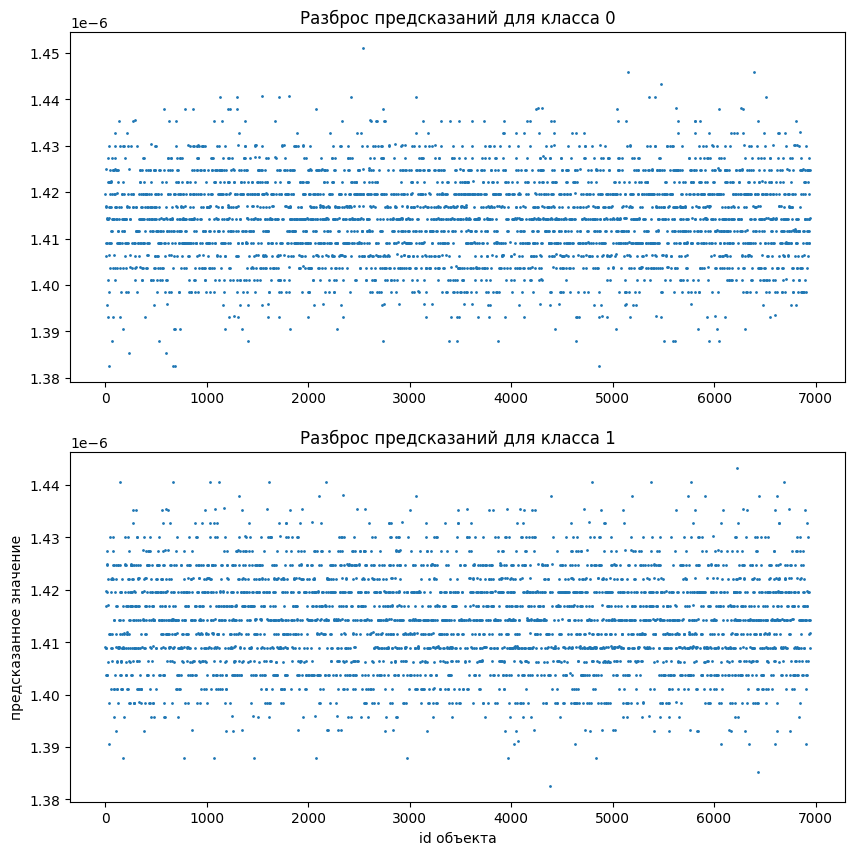

In [10]:
draw_reid_predict(td)

In [13]:
get_binary_accuracy(td, thresholds[-1])

0.4966887417218543